# RBIG Demo

In [1]:
!pip install "git+https://github.com/IPL-UV/rbig.git"

import numpy as np
import warnings
from time import time
from rbig.rbig import RBIG, entropy
# from rbig.model import RBIG
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings('ignore') # get rid of annoying warnings

%matplotlib inline
%load_ext autoreload
%autoreload 2

  Cloning https://github.com/IPL-UV/rbig.git to /tmp/pip-req-build-irp4xlah
  Created wheel for py-rbig: filename=py_rbig-0.0.1-py3-none-any.whl size=31742 sha256=267fdd8a5df19f82562a1f8e808a7dd9bcf62460aae5becac5cd38df09280410
  Stored in directory: /tmp/pip-ephem-wheel-cache-cqfir6sc/wheels/30/26/cc/9a69d7a7c01d8b08395bee2ac2af9de7321052ec694213c749
Successfully built py-rbig


#### Toy Data

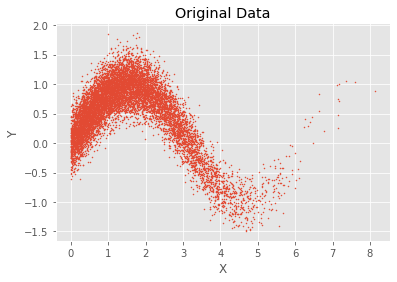

In [2]:
seed = 123
rng = np.random.RandomState(seed=seed)

num_samples = 10000
x = np.abs(2 * rng.randn(1, num_samples))
y = np.sin(x) + 0.25 * rng.randn(1, num_samples)
data = np.vstack((x, y)).T

fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Original Data')
plt.show()

## RBIG Fitting

In [3]:
%%time 

n_layers = 1000
rotation_type = 'pca'
random_state = 123

# Initialize RBIG class
rbig_model = RBIG(n_layers=n_layers, rotation_type=rotation_type, 
                  random_state=random_state)

# transform data
data_trans = rbig_model.fit_transform(data)

CPU times: user 2.19 s, sys: 17.3 ms, total: 2.21 s
Wall time: 558 ms


In [4]:
rbig_model

RBIG(n_layers=30, pdf_extension=10, random_state=123, rotation_type='pca',
     tolerance=array(0.0145))

### Transform Data into Gaussian

(10000, 2)


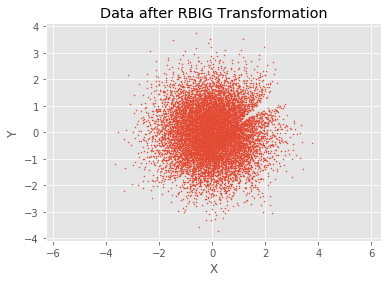

In [5]:
print(data_trans.shape)
fig, ax = plt.subplots()
ax.scatter(data_trans[:, 0], data_trans[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data after RBIG Transformation')
ax.axis('equal')
plt.show()

### Invertible

In [6]:
%%time
# transform data
data_approx = rbig_model.inverse_transform(data_trans)

# check approximation
np.testing.assert_array_almost_equal(data, data_approx)

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 40 / 20000 (0.2%)
Max absolute difference: 1.54271179
Max relative difference: 1.14183533
 x: array([[2.171261, 0.514831],
       [1.994691, 0.833257],
       [0.565957, 0.323987],...
 y: array([[2.171261, 0.514831],
       [1.994691, 0.833257],
       [0.565957, 0.323987],...

#### Check Residuals

In [7]:
data_approx = rbig_model.inverse_transform(data_trans)
residual = np.abs(data - data_approx).sum().sum()

print(f'Residual from Original and Transformed: {residual:.2e}')

Residual from Original and Transformed: 3.29e+00


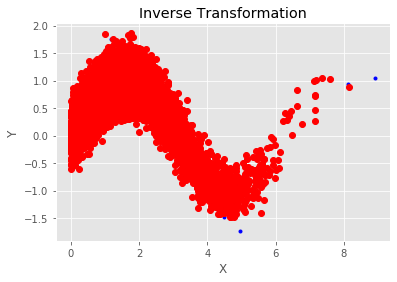

In [8]:
fig, ax = plt.subplots()
ax.plot(data_approx[:, 0], data_approx[:, 1], 'b.')
ax.plot(data[:, 0], data[:, 1], 'ro')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Inverse Transformation')
plt.show()

### Information Reduction

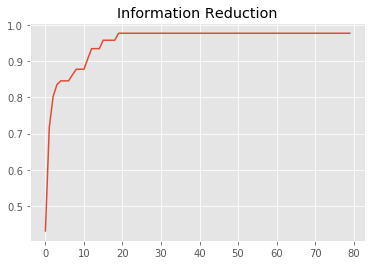

In [9]:
residual_info = rbig_model.residual_info

fig, ax = plt.subplots()
ax.plot(np.cumsum(rbig_model.residual_info))
ax.set_title('Information Reduction')
plt.show()

### Generated Synthetic Data

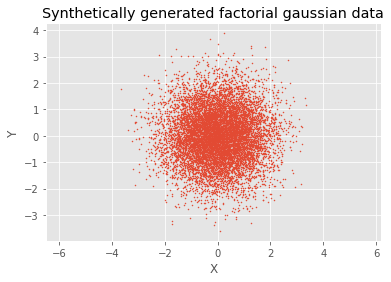

In [10]:
data_synthetic = rng.randn(data.shape[0], data.shape[1])

fig, ax = plt.subplots()
ax.scatter(data_synthetic[:, 0], data_synthetic[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Synthetically generated factorial gaussian data')
ax.axis('equal')
plt.show()

### Synthesize New Data from RBIG Model

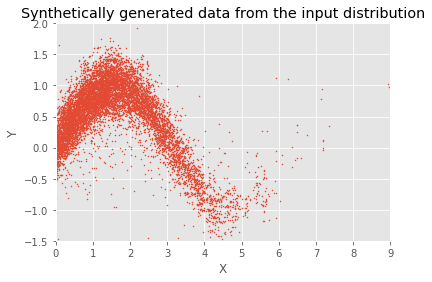

In [11]:
data_original_synthetic = rbig_model.inverse_transform(data_synthetic)

fig, ax = plt.subplots()
ax.scatter(data_original_synthetic[:, 0], data_original_synthetic[:, 1], s=1)
# ax.scatter(data[:, 0], data[:, 1], s=1)

ax.set_ylim([-1.5, 2.0])
ax.set_xlim([0.0, 9.0])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Synthetically generated data from the input distribution')
plt.show()

### Jacobian

In [12]:
%%time

jacobian = rbig_model.jacobian(data, return_X_transform=False)

print(jacobian.shape)

print(f"Jacobian - min: {jacobian.min():.3e}, max: {jacobian.max():.3e}")

(10000, 2, 2)
Jacobian - min: -4.193e+08, max: 5.553e+09
CPU times: user 595 ms, sys: 48.7 ms, total: 643 ms
Wall time: 161 ms


### Estimating Probabilities with RBIG

In [13]:
%%time
prob_input, prob_gauss = rbig_model.predict_proba(data, domain='both', n_trials=1)
print(f"Prob Input Domain - min: {prob_input.min():.3e}, max: {prob_input.max():.3e}")
print(f"Prob Gauss Domain - min: {prob_gauss.min():.3e}, max: {prob_gauss.max():.3e}")
print(f"Det:: {rbig_model.det_jacobians:.3e}")

Prob Input Domain - min: 5.348e-23, max: 2.170e+03
Prob Gauss Domain - min: 5.325e-05, max: 1.591e-01
Det:: -1.381e+03
CPU times: user 761 ms, sys: 3.53 ms, total: 764 ms
Wall time: 191 ms


### Original Data with Probabilities

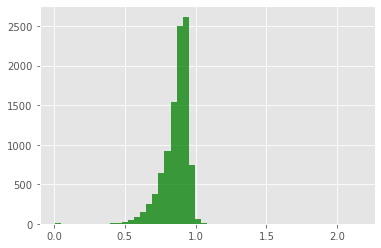

In [14]:
fig, ax = plt.subplots()
ax.hist(prob_input**0.1, 50, facecolor='green', alpha=0.75)
plt.show()

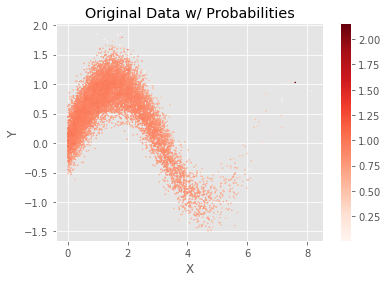

In [15]:
fig, ax = plt.subplots()

h = ax.scatter(data[:, 0], data[:, 1], s=1, c=prob_input**0.1, cmap='Reds')

ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = plt.colorbar(h, )
ax.set_title('Original Data w/ Probabilities')
plt.show()

### Probability in Gaussian Domain

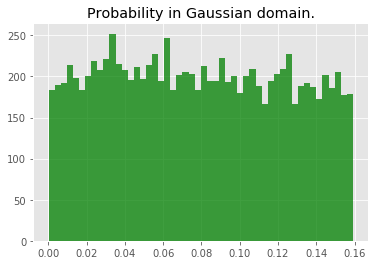

In [16]:
# Plot the probability of the data in the Gaussian Domain
fig, ax = plt.subplots()

n, bins, patches = ax.hist(prob_gauss, 50, facecolor='green', alpha=0.75)
ax.set_title('Probability in Gaussian domain.')
plt.show()

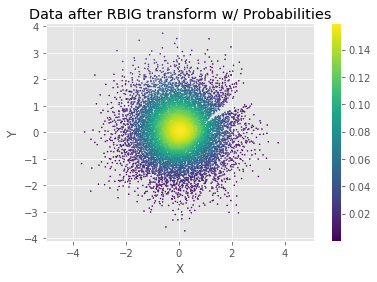

In [17]:
# Plot the Probabilities of the data using colors
fig, ax = plt.subplots()
g = ax.scatter(data_trans[:, 0], data_trans[:, 1],
               s=1, c=prob_gauss)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data after RBIG transform w/ Probabilities')
ax.axis('equal')
plt.colorbar(g)
plt.show()